Principal Components Regression PCR consiste en ajustar un modelo de regresión lineal por mínimos cuadrados empleando como predictores las componentes generadas a partir de un Principal Component Analysis (PCA). 

In [1]:
# Basado en https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

# Tratamiento de datos

# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos
# se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, 
# cuyo contenido en grasa se obtiene también por análisis químico, 
# Se busca entrenar un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro
# ==============================================================================
datos = pd.read_csv('https://raw.githubusercontent.com/DianaSofiaOlano/dataSetsIA/main/train.csv')
datos = datos.drop(columns = datos.columns[0])

# Identify the categorical variables with data type 'object'
cat_vars = datos.select_dtypes(include=['object']).columns.tolist()

# Delete the categorical variables from the dataset
df = datos.drop(cat_vars, axis=1)

#Delete null values
df = df.dropna()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1121 non-null   int64  
 1   LotFrontage    1121 non-null   float64
 2   LotArea        1121 non-null   int64  
 3   OverallQual    1121 non-null   int64  
 4   OverallCond    1121 non-null   int64  
 5   YearBuilt      1121 non-null   int64  
 6   YearRemodAdd   1121 non-null   int64  
 7   MasVnrArea     1121 non-null   float64
 8   BsmtFinSF1     1121 non-null   int64  
 9   BsmtFinSF2     1121 non-null   int64  
 10  BsmtUnfSF      1121 non-null   int64  
 11  TotalBsmtSF    1121 non-null   int64  
 12  1stFlrSF       1121 non-null   int64  
 13  2ndFlrSF       1121 non-null   int64  
 14  LowQualFinSF   1121 non-null   int64  
 15  GrLivArea      1121 non-null   int64  
 16  BsmtFullBath   1121 non-null   int64  
 17  BsmtHalfBath   1121 non-null   int64  
 18  FullBath

In [4]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))



,variable_1,variable_2,r,abs_r
951,GarageCars,GarageArea,0.839415,0.839415
987,GarageArea,GarageCars,0.839415,0.839415
455,1stFlrSF,TotalBsmtSF,0.835999,0.835999
419,TotalBsmtSF,1stFlrSF,0.835999,0.835999
829,TotRmsAbvGrd,GrLivArea,0.824312,0.824312


In [5]:
# # (correlación absoluta > 0.8), lo que supone un problema a la hora de emplear modelos de regresión lineal

# División de los datos en train y test
# ==============================================================================
X = df.drop(columns='SalePrice')
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Se ajustan dos modelos lineales, uno con todos los predictores y otro con solo algunas de las componentes obtenidas por PCA, con el objetivo de identificar cuál de ellos es capaz de predecir mejor el contenido en grasa de la carne en función de las señales registradas por el espectrofotómetro.



In [6]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)


LinearRegression()

In [7]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 55554.318515037485


In [8]:
# Entrenamiento modelo de regresión precedido por PCA con escalado

# ==============================================================================

pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())

pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [9]:
pipe_modelado.set_params

<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [10]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 56326.298000595736


In [11]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5, random_state=123,shuffle=True), 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
        

       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(3)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
3,6,-41401.509945,12681.318691,-41584.594062,3672.299849
4,8,-41484.107648,12789.059167,-41294.894678,3787.501970
5,10,-41707.385883,12301.639919,-40765.862780,3517.225970


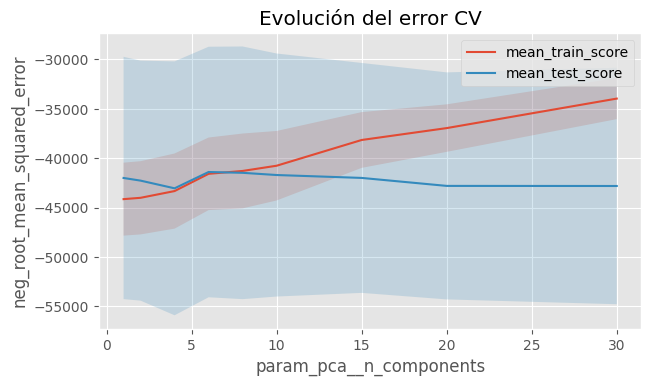

In [12]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [13]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 6} : -41401.50994502704 neg_root_mean_squared_error


In [14]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('linearregression', LinearRegression())])

In [15]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 39749.8854395611


In [ ]:
# Based on: Análisis de componentes princiaples PCA con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py19-pca-python.html

